# Growth accounting for manufacturing industry in Singapore

In [107]:
import pandas as pd
def normalize_data(path: str, header: int = 10, nrows: int | None = 23) -> pd.DataFrame:
  df = pd.read_csv(path, header=header, index_col=0, nrows=nrows)
  df.columns = df.columns.astype(int).astype(str)
  df.index = [str(row).strip() for row in df.index]
  for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")
  return df



In [108]:
import statsmodels.api as sm
import pandas as pd
from typing import TypedDict

class LinearRegressionParameters(TypedDict):
  constant: float
  coefficient: float
  residuals: pd.Series

def time_series_linear_regression(
  target_values: pd.Series,
  independent_values: pd.Series
) -> LinearRegressionParameters:
  """
  Perform OLS regression for time series data.
  Model: target = constant + coefficient * independent + residual
  Args:
    target_values (pd.Series): dependent variable (e.g. ln(Y/K))
    independent_values (pd.Series): time variable or explanatory variable (e.g. year)
  Returns:
    dict: constant, coefficient, residuals
  """

  model = sm.OLS(
    target_values, 
    sm.add_constant(independent_values)
    ).fit()

  # 残差に時系列インデックスを保持
  residuals = model.resid
  residuals.index = target_values.index

  return {
    "constant": model.params["const"],
    "coefficient": model.params[independent_values.name],
    "residuals": residuals
  }


In [109]:
from statsmodels.tsa.filters.hp_filter import hpfilter
import pandas as pd
from typing import Literal

def hp_filter_trend(
    target_series: pd.Series,
    time_scale: Literal["yearly", "quarterly", "monthly"] = "yearly",
    with_cycle: bool | None = False
) -> pd.Series | tuple[pd.Series, pd.Series]:
    """
    Apply Hodrick-Prescott (HP) filter to extract the trend component
    from a time-series variable (e.g. productivity, utilization).
    Args:
        target_series (pd.Series): 時系列データ（インデックスは時系列）
        time_scale (str): "yearly", "quarterly", または "monthly"
    Returns:
        pd.Series: トレンド成分（trend component）
    """
    if time_scale == "yearly":
        lamb = 6.25
    elif time_scale == "quarterly":
        lamb = 1600
    elif time_scale == "monthly":
        lamb = 14400
    else:
        raise ValueError("time_scale must be 'yearly', 'quarterly', or 'monthly'.")

    cycle, trend = hpfilter(target_series, lamb=lamb)
    trend.index = target_series.index  # 元の時系列インデックスを保持
    if not with_cycle:
        return trend
    else:
        cycle.index = target_series.index 
        return cycle, trend
    


## Value Addition (Y)

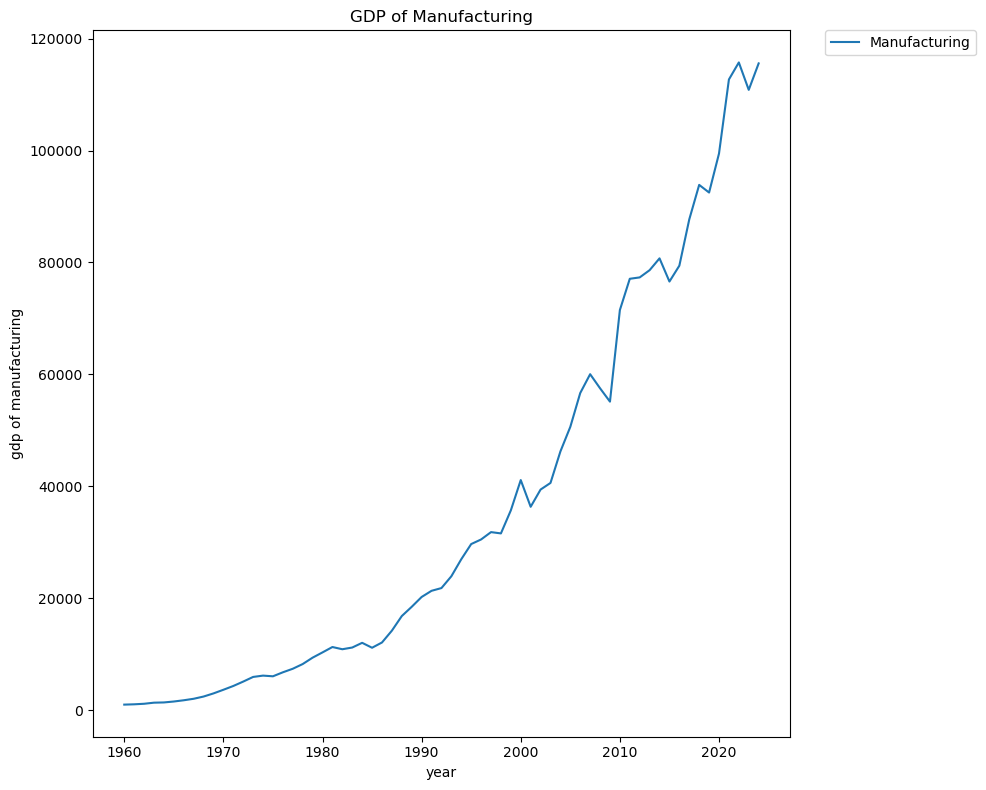

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

gdp_manufacturing = normalize_data("./data/singapore/sg_gdp_in_chained_by_industry.csv").iloc[2, :].sort_index()

ax = gdp_manufacturing.plot(figsize=(10, 8))

# 凡例をプロットの外に配置 (右上に配置)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# タイトルと軸ラベルを追加（必要に応じて）
plt.title('GDP of Manufacturing')
plt.xlabel('year')
plt.ylabel('gdp of manufacturing')

# レイアウトを調整して、凡例がグラフを隠さないようにする
plt.tight_layout()

# 表示
plt.show()


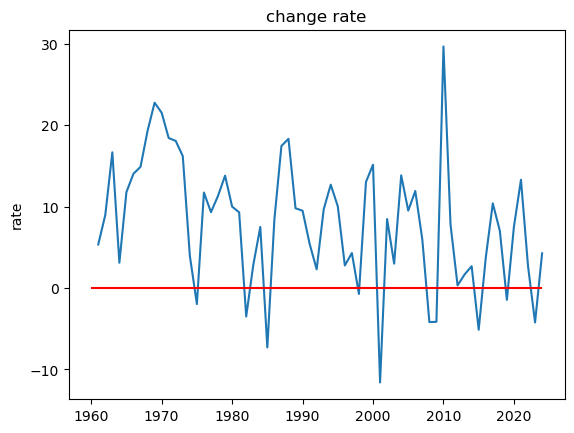

In [111]:
from matplotlib import pyplot as plt
plt.plot(gdp_manufacturing.pct_change()* 100)
plt.title("change rate")
plt.ylabel("rate")
plt.hlines(0, gdp_manufacturing.index[0], gdp_manufacturing.index[-1], color="red")
tick_positions = []
tick_lables = []
for i, year in enumerate(gdp_manufacturing.index):
  if int(year) % 10 == 0:
    tick_positions.append(i)
    tick_lables.append(year)
plt.xticks(tick_positions, tick_lables)
plt.show()

## Labor Input (L)

### Employees

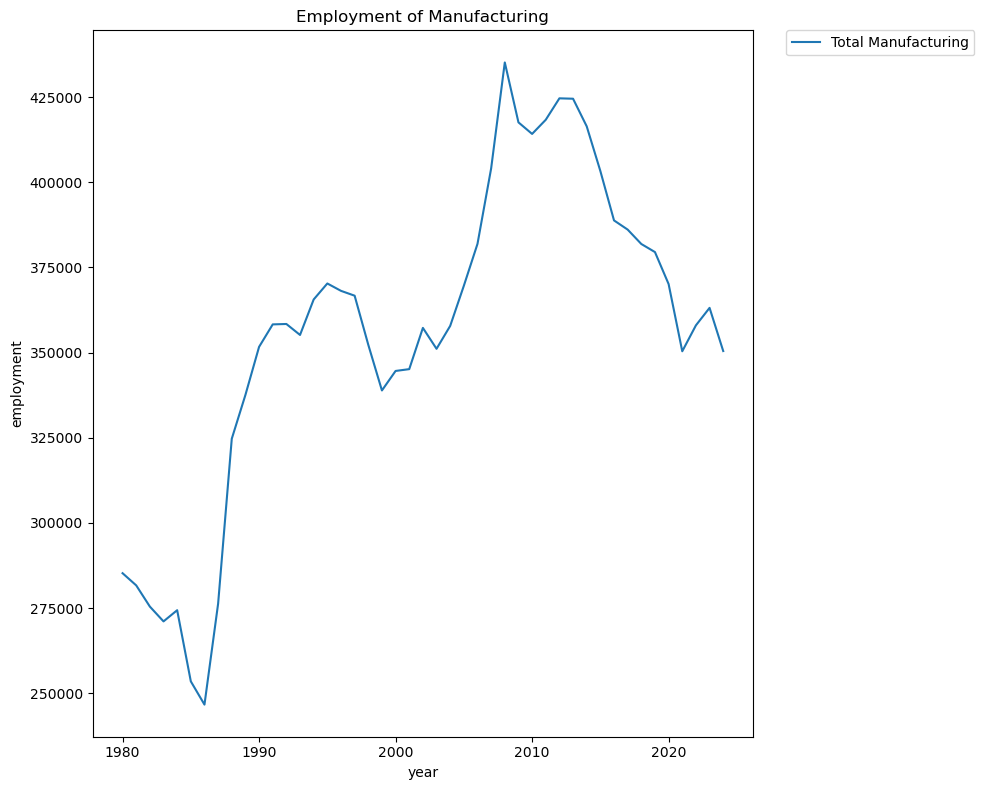

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# Refer to https://www.singstat.gov.sg/find-data/search-by-theme/industry/manufacturing/latest-data

employment_total_manufacturing = normalize_data("./data/singapore/sg_manufac_workers_by_industry.csv").loc["Total Manufacturing"].sort_index()


ax = employment_total_manufacturing.plot(figsize=(10, 8))

# 凡例をプロットの外に配置 (右上に配置)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# タイトルと軸ラベルを追加（必要に応じて）
plt.title('Employment of Manufacturing')
plt.xlabel('year')
plt.ylabel('employment')

# レイアウトを調整して、凡例がグラフを隠さないようにする
plt.tight_layout()

# 表示
plt.show()


### working hours 

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


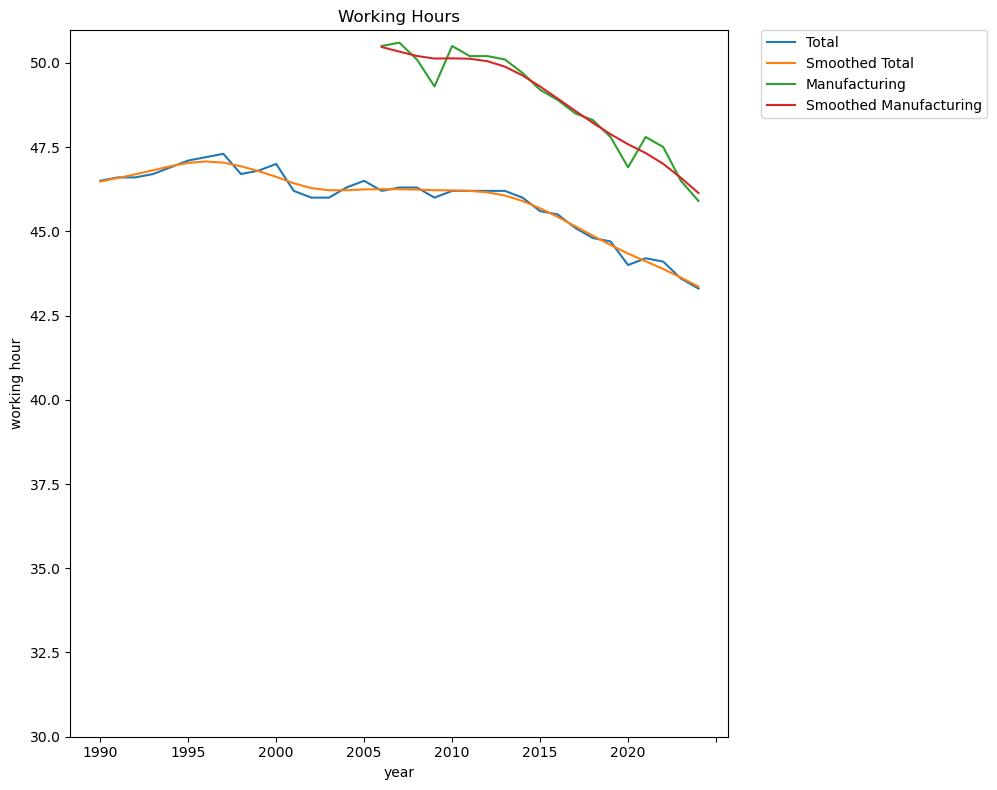

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Refer to https://www.singstat.gov.sg/find-data/search-by-theme/industry/manufacturing/latest-data


working_hours_df = normalize_data("./data/singapore/sg_working_hours.csv", nrows=15)

working_hours = pd.DataFrame({
  "Total": working_hours_df.iloc[0, :],
  "Smoothed Total": hp_filter_trend(working_hours_df.iloc[0, :], "yearly"),
  "Manufacturing": working_hours_df.iloc[1, :],
  "Smoothed Manufacturing": hp_filter_trend(working_hours_df.iloc[1, :].dropna(), "yearly")
  }).sort_index()


ax = working_hours.plot(figsize=(10, 8))


# 凡例をプロットの外に配置 (右上に配置)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# タイトルと軸ラベルを追加（必要に応じて）
plt.title('Working Hours')
plt.xlabel('year')
plt.ylabel('working hour')

# レイアウトを調整して、凡例がグラフを隠さないようにする
plt.tight_layout()

plt.ylim(30)

# 表示
plt.show()


## Capital(K)

In [114]:
import requests
import pandas as pd

def to_dataset(url: str):
  response = requests.get(url)
  data = response.json()

  # レコード部分を抽出
  records = data["result"]["records"]

  # pandas DataFrame へ変換
  df = pd.DataFrame(records)

  # 数値列を float に変換（JSONからは文字列で来ることが多い）
  for col in df.columns:
    if col not in ["_id", "DataSeries"]:
      df[col] = pd.to_numeric(df[col], errors="coerce")

  # DataSeries を index にすると見やすい
  df.set_index("DataSeries", inplace=True)
  df.drop(columns="_id", inplace=True)

  return df

In [115]:
total_real_net_capital_stock = normalize_data("./data/singapore/sg_net_capital_stock.csv", nrows=15).loc["Total"].sort_index()

In [116]:
import pandas as pd

def calculate_gdp_share(total_capital_stock: pd.Series) -> tuple[pd.Series, pd.Series]:
    """GDP比率で製造業の資本ストックを分配する"""
    gdp_data = to_dataset("https://data.gov.sg/api/action/datastore_search?resource_id=d_d0db56a7c201c9a1e42c846d4fe6da8f")
    gdp_total = gdp_data.iloc[0, :]
    gdp_manufacturing = gdp_data.iloc[2, :]
    
    share_series = gdp_manufacturing / gdp_total
    capital_stock_share = total_capital_stock * share_series
    capital_stock_share.index = capital_stock_share.index.astype(int).astype(str)
    
    return capital_stock_share.dropna(), share_series

def calculate_real_gos_share(total_capital_stock: pd.Series) -> tuple[pd.Series, pd.Series]:
    """実質営業余剰（GOS）比率で製造業の資本ストックを分配する"""
    # デフレーターを読み込み
    deflators = normalize_data("./data/singapore/sg_gdp_deflator_by_industry.csv")
    gdp_deflator = deflators.iloc[0].sort_index()["1980":]
    manufacturing_deflator = deflators.iloc[2].sort_index()["1980":]

    # 名目営業余剰を読み込み
    operating_surplus = normalize_data("./data/singapore/sg_operating_surplus.csv")
    operating_surplus_total = operating_surplus.loc["Total"].sort_index()
    operating_surplus_manufacturing = operating_surplus.loc["Manufacturing"].sort_index()

    # 実質値に変換
    real_operating_surplus_total = operating_surplus_total * 100 / gdp_deflator
    real_operating_surplus_manufacturing = operating_surplus_manufacturing * 100 / manufacturing_deflator
    
    share_series = real_operating_surplus_manufacturing / real_operating_surplus_total
    capital_stock_share = total_capital_stock * share_series
    capital_stock_share.index = capital_stock_share.index.astype(int).astype(str)
    
    return capital_stock_share.dropna(), share_series

def calculate_fixed_assets_share(total_capital_stock: pd.Series) -> tuple[pd.Series, pd.Series]:
    """固定資産比率で製造業の資本ストックを分配する"""
    fixed_assets = normalize_data("./data/singapore/sg_balance_sheet_of_corporate_by_industry.csv", nrows=None).loc["Property, Plant & Equipment"]
    total_fixed_assets = fixed_assets.iloc[0].sort_index()
    manufacturing_fixed_assets = fixed_assets.iloc[1].sort_index()
    print(total_fixed_assets)
    print(manufacturing_fixed_assets)

    share_series = manufacturing_fixed_assets / total_fixed_assets
    capital_stock_share = total_capital_stock * share_series
    capital_stock_share.index = capital_stock_share.index.astype(int).astype(str)
    
    return capital_stock_share.dropna(), share_series

In [117]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def calculate_capacity_utilization(Y: pd.Series, K: pd.Series):
  """"
    In(Y/K) = C + γt + ut \n
    ut' = hp(ut) \n
    St = exp(ut' - u‾)
  """
  target_value = np.log( Y / K ).dropna()
  target_value.name = "gdp per capital"
  independent_values = pd.Series(target_value.index.astype(int), index=target_value.index, name="year")
  capital_utilization_values_by_real_surplus = time_series_linear_regression(target_value, independent_values)['residuals']

  # HPフィルターで滑らかにする
  smoothed_capital_utilization_values_by_real_surplus = hp_filter_trend(
    capital_utilization_values_by_real_surplus, "yearly"
  )

  # 平均をゼロに揃えてから指数化（基準平均を1にする）
  smoothed_capital_utilization_values_by_real_surplus = smoothed_capital_utilization_values_by_real_surplus - smoothed_capital_utilization_values_by_real_surplus.mean()
  S_t = np.exp(smoothed_capital_utilization_values_by_real_surplus)
  S_t.name = "capacity_utilization_ratio"

  return S_t


### Capital Input

In [118]:
# --- 資本ストックの分配比率と製造業資本ストックを計算 ---
# GDP比率
capital_stock_by_gdp, gdp_sharing_series = calculate_gdp_share(total_real_net_capital_stock)

# 実質営業余剰比率
capital_stock_by_real_surplus, real_operating_sharing_series = calculate_real_gos_share(total_real_net_capital_stock)

# 固定資産比率
capital_stock_by_fixed_assets, asset_sharing_series = calculate_fixed_assets_share(total_real_net_capital_stock)

# --- 名目営業余剰比率も計算（比較用） ---
operating_surplus = normalize_data("./data/singapore/sg_operating_surplus.csv")
operating_surplus_total = operating_surplus.loc["Total"].sort_index()
operating_surplus_manufacturing = operating_surplus.loc["Manufacturing"].sort_index()
nominal_operating_sharing_series = operating_surplus_manufacturing / operating_surplus_total

2009    256714.0
2010    269219.0
2011    278629.0
2012    281802.0
2013    299802.0
2014    350473.0
2015    372026.0
2016    368619.0
2017    369007.0
2018    388188.0
2019    446864.0
2020    487690.0
2021    509453.0
2022    540989.0
2023    547105.0
Name: Property, Plant & Equipment, dtype: float64
2009     68915.0
2010     69051.0
2011     68590.0
2012     69346.0
2013     70920.0
2014     72835.0
2015     75730.0
2016     78550.0
2017     79548.0
2018     80470.0
2019     88162.0
2020     88196.0
2021     90705.0
2022    100018.0
2023     96376.0
Name: Property, Plant & Equipment, dtype: float64


### capacity utilization

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


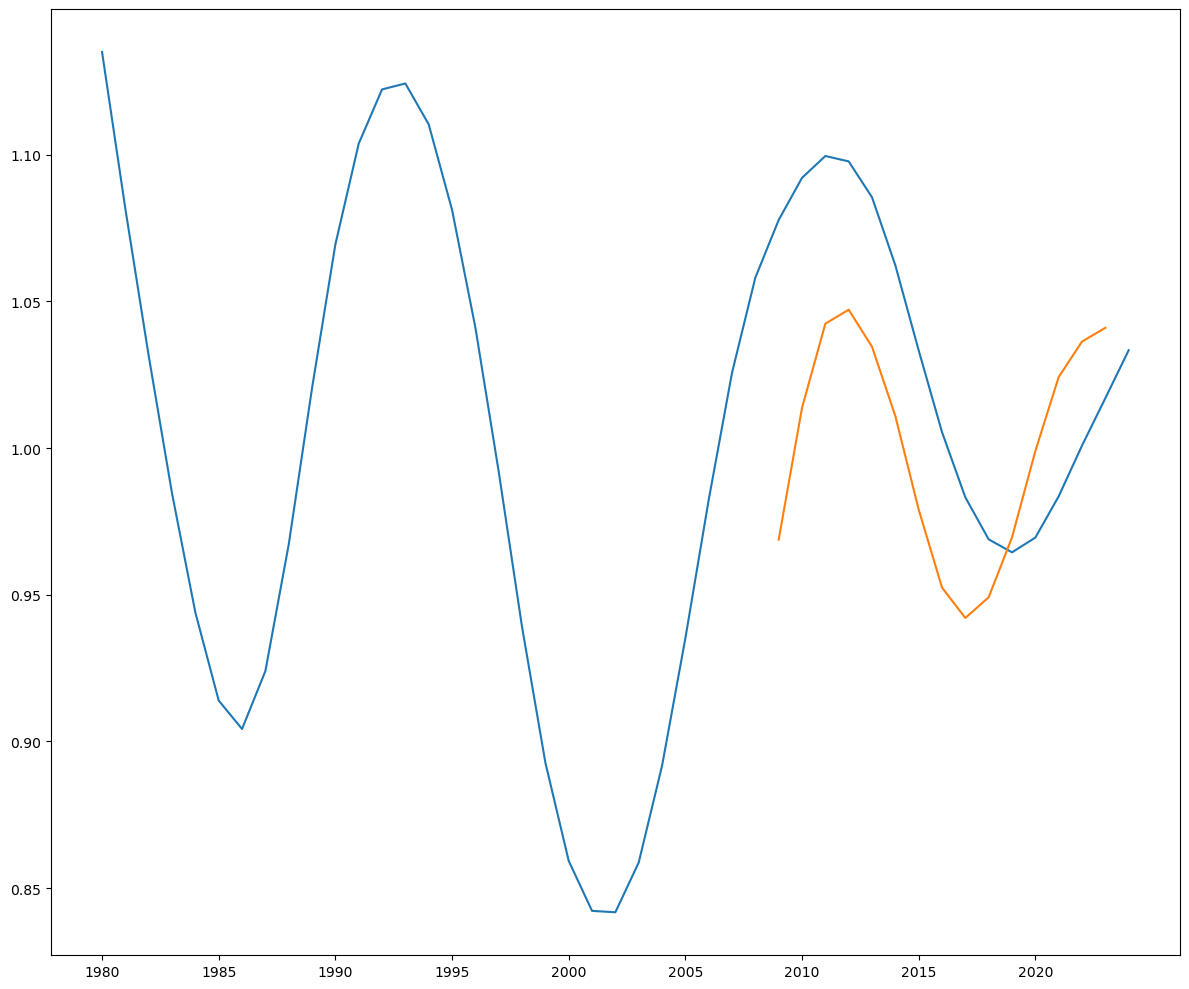

In [119]:
from matplotlib import pyplot as plt

# 稼働率（比率）として指数化する
capital_utilization_ratio_by_real_surplus = calculate_capacity_utilization(gdp_manufacturing, capital_stock_by_real_surplus)

capital_utilization_ratio_by_fixed_asset = calculate_capacity_utilization(gdp_manufacturing, capital_stock_by_fixed_assets)

plt.subplots(figsize=(12, 10))
plt.plot(capital_utilization_ratio_by_real_surplus , label="Capital Utilization by Real GOS")
plt.plot(capital_utilization_ratio_by_fixed_asset, label="Capital Utilization by Real Fixed assets")

ranges = [index for index in range(len(capital_stock_by_real_surplus)) if index % 5 == 0]

plt.xticks(
  ticks=ranges,
  labels=capital_utilization_ratio_by_real_surplus.iloc[ranges].index
)
plt.tight_layout()
plt.show()


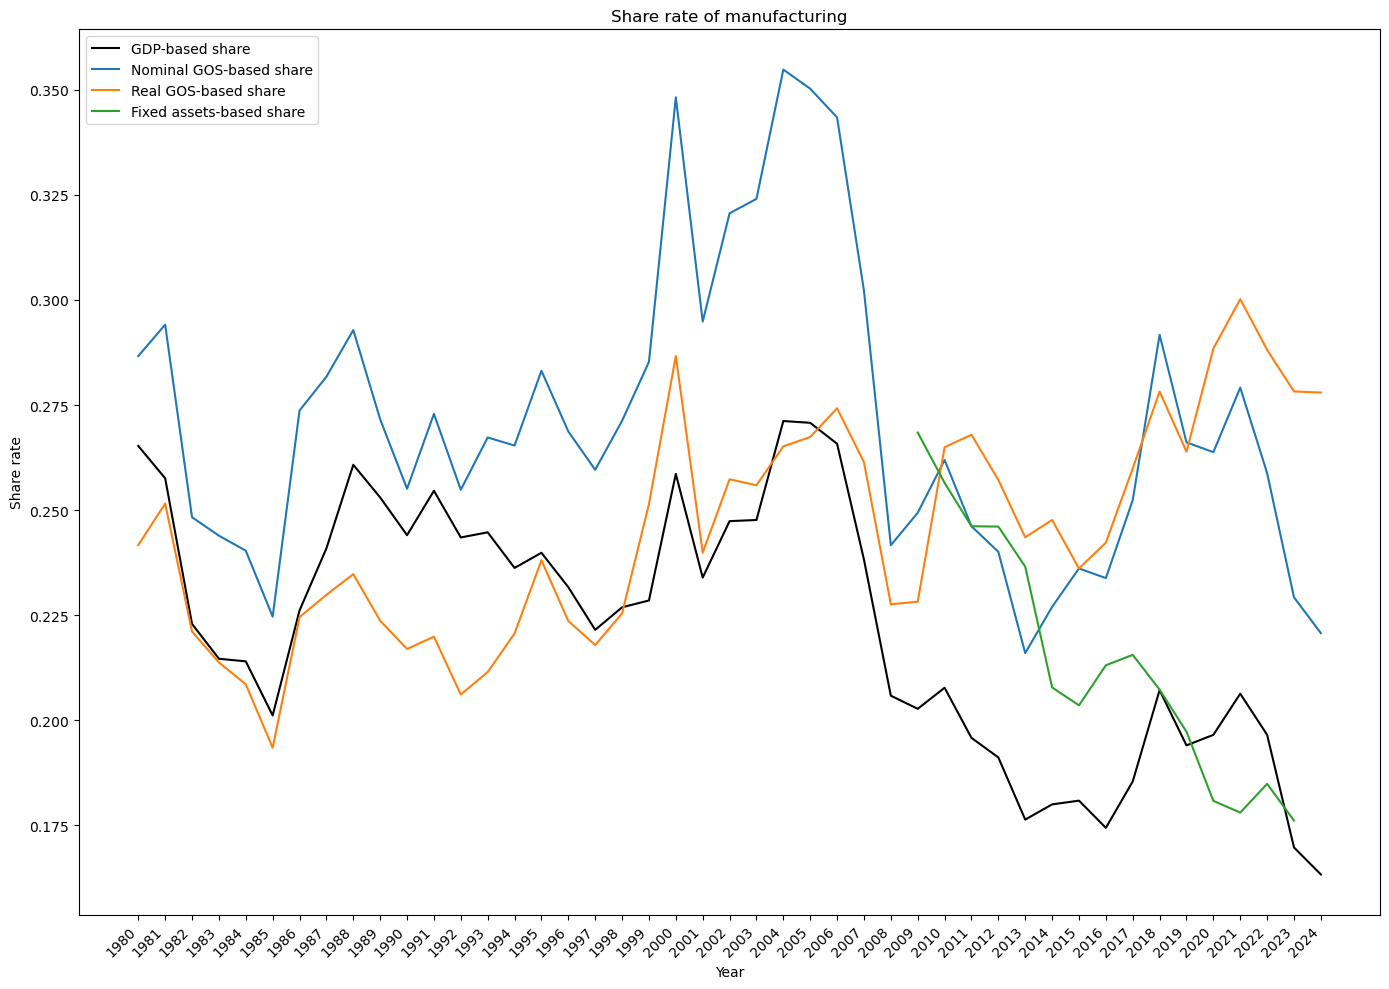

In [120]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Share rate of manufacturing")
ax.set_xlabel("Year")
ax.set_ylabel("Share rate")

# 各系列をプロット（labelを指定）
ax.plot(gdp_sharing_series.loc["1980":], label="GDP-based share", color="black")
ax.plot(nominal_operating_sharing_series, label="Nominal GOS-based share")
ax.plot(real_operating_sharing_series, label="Real GOS-based share")
ax.plot(asset_sharing_series, label="Fixed assets-based share")

# X軸の設定
ax.set_xticks(range(len(gdp_sharing_series.loc["1980":])))
ax.set_xticklabels(
    gdp_sharing_series.loc["1980":].index.astype(int),
    rotation=45, ha="right"
)

# 凡例
ax.legend(loc="upper left")

fig.tight_layout()
plt.show()


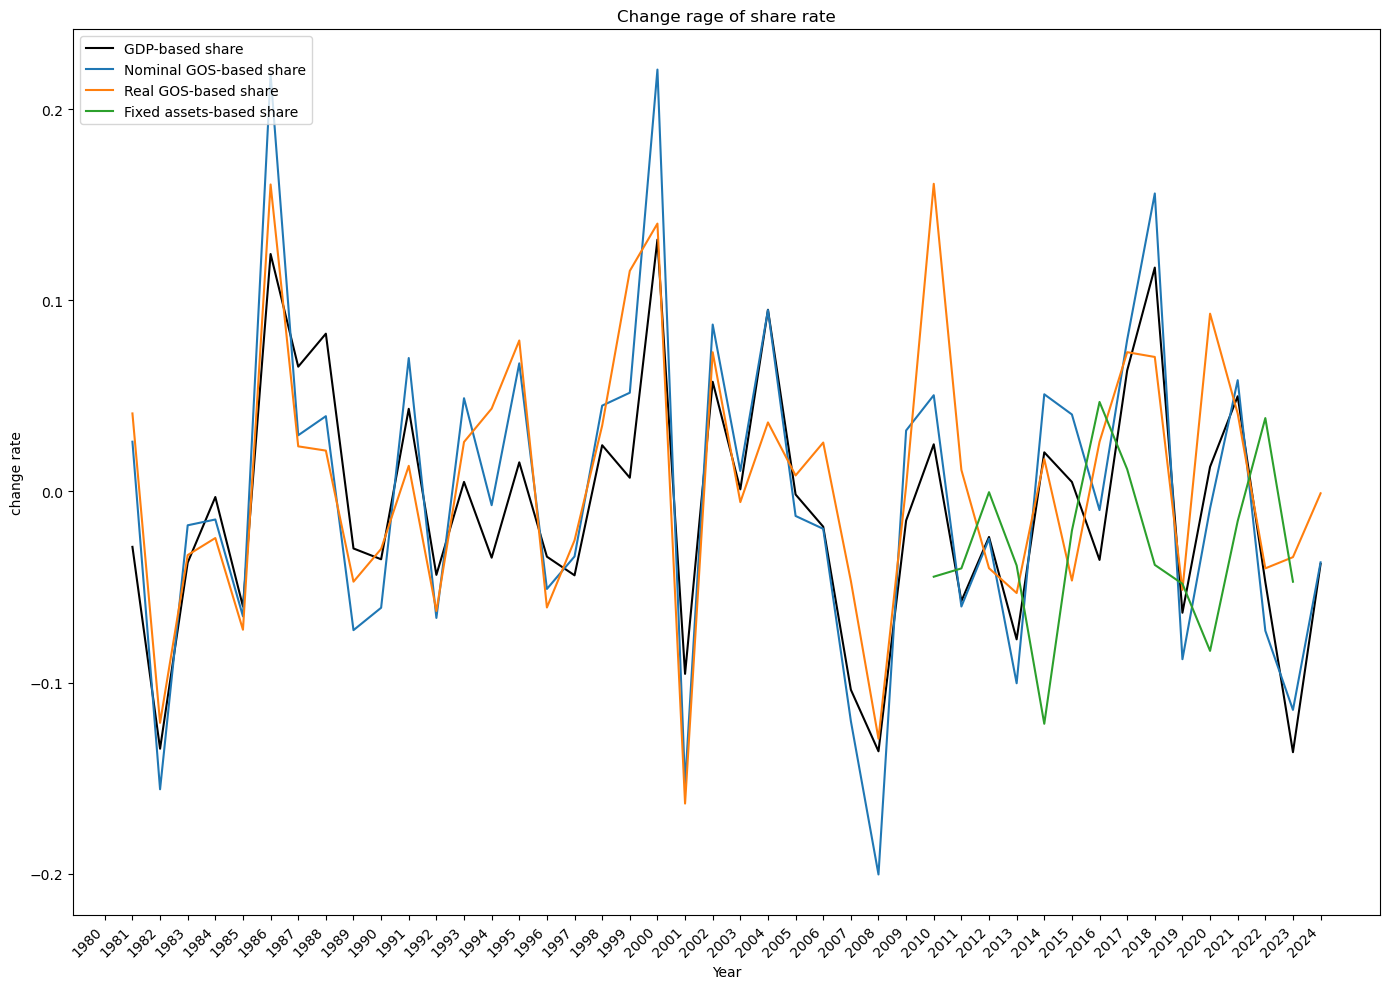

In [121]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Change rage of share rate")
ax.set_xlabel("Year")
ax.set_ylabel("change rate")

# 各系列をプロット（labelを指定）
ax.plot(gdp_sharing_series.loc["1980":].pct_change(), label="GDP-based share", color="black")
ax.plot(nominal_operating_sharing_series.pct_change(), label="Nominal GOS-based share")
ax.plot(real_operating_sharing_series.pct_change(), label="Real GOS-based share")
ax.plot(asset_sharing_series.pct_change(), label="Fixed assets-based share")

# X軸の設定
ax.set_xticks(range(len(gdp_sharing_series.loc["1980":])))
ax.set_xticklabels(
    gdp_sharing_series.loc["1980":].index.astype(int),
    rotation=45, ha="right"
)

# 凡例
ax.legend(loc="upper left")

fig.tight_layout()
plt.show()


## Labor/Capital Distribution (α,β)

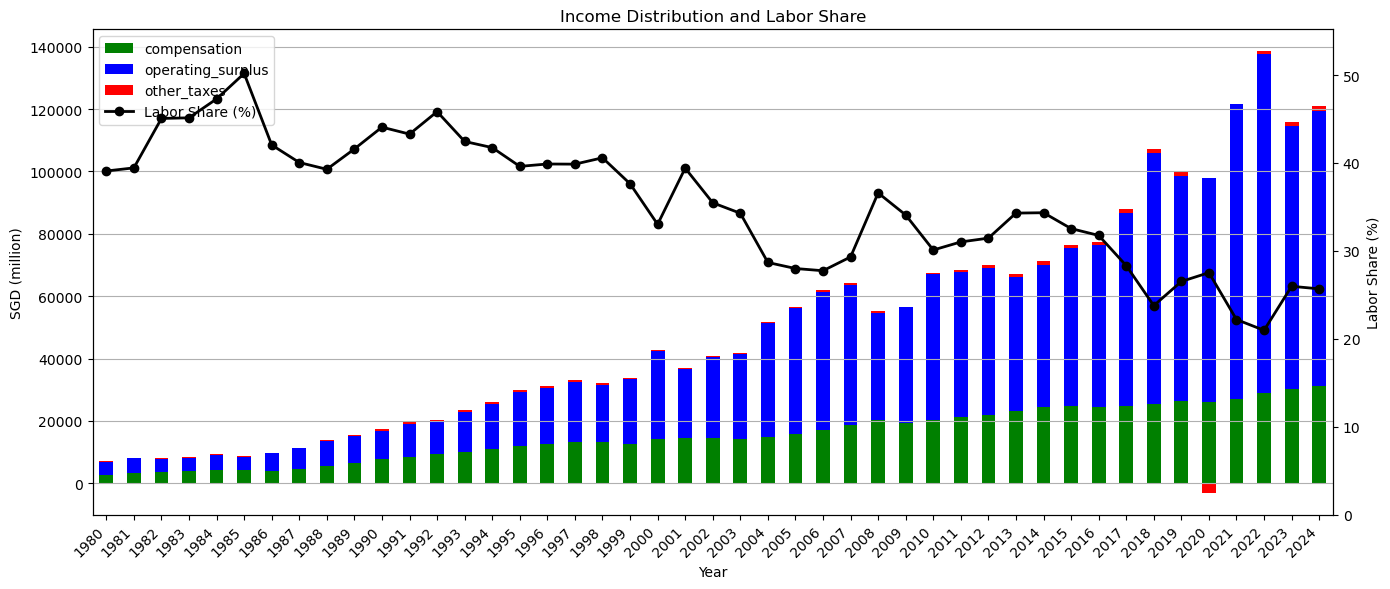

In [122]:
# refer to https://www.singstat.gov.sg/find-data/search-by-theme/economy/national-accounts/visualising-data/income-components-of-gdp-dashboard
# To derive this values by year, you have to combine three data set from compensation of employee, operating surplus, and taxes less subsidies on production and import.
import pandas as pd
import matplotlib.pyplot as plt


compensation_manufacture = normalize_data("./data/singapore/sg_compensation_for_workers.csv", nrows=25).iloc[1, :]
operating_surplus_manufacture = normalize_data("./data/singapore/sg_operating_surplus.csv", nrows=25).iloc[1, :]
other_taxes_manufacture = normalize_data("./data/singapore/sg_other_taxes_less_subsidies.csv", nrows=25).iloc[1, :]

# --- DataFrame 作成 ---
df = pd.DataFrame({
  "compensation": compensation_manufacture,
  "operating_surplus": operating_surplus_manufacture,
  "other_taxes": other_taxes_manufacture
}).sort_index()

# --- 労働分配率（%）を計算 ---
df["labor_share"] = df["compensation"] / (df["compensation"] + df["operating_surplus"] + df["other_taxes"])
labor_distribution = df["labor_share"]
labor_distribution_pct = df["labor_share"] * 100  # % 表示に変換

# --- プロット ---
fig, ax1 = plt.subplots(figsize=(14,6))

# 積み上げ棒グラフ（左軸）
df[["compensation", "operating_surplus", "other_taxes"]].plot(
  kind="bar", stacked=True, ax=ax1, color=["green", "blue", "red"], legend=True
)
ax1.set_ylabel("SGD (million)")
ax1.set_xlabel("Year")
ax1.set_title("Income Distribution and Labor Share")
ax1.grid(axis="y")

# secondary y-axis を使って折れ線（右軸）
ax2 = ax1.twinx()

# x の位置を棒と合わせる（bar の中心は 0..len-1）
x = range(len(df))

# 折れ線を目立たせる（色・線幅・マーカー・zorder）
ax2.plot(
  x, labor_distribution_pct.values,
  color="black", marker="o", linewidth=2, markersize=6, zorder=3, label="Labor Share (%)"
)

# 右軸ラベルと範囲（見やすいように余裕を持たせる）
min_v = max(0, labor_distribution_pct.min() * 0.9)
max_v = labor_distribution_pct.max() * 1.1
ax2.set_ylim(min_v, max_v)
ax2.set_ylabel("Labor Share (%)")

# x 軸ラベルを年に戻す（回転で見やすく）
ax1.set_xticks(x)
ax1.set_xticklabels(df.index.astype(int), rotation=45, ha="right")

# secondary axis を透明にして折れ線がバーの上に描かれるようにする
ax2.set_zorder(ax1.get_zorder() + 1)
ax2.patch.set_visible(False)

ax2.set_ylim(0)

# 凡例（左右両方の凡例をまとめて表示）
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()
plt.show()



## Calculation

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class GrowthAccounter:
  def __init__(self, Y: pd.Series, K: pd.Series, L: pd.Series, labor_share: pd.Series):
    self.Y = Y
    self.K = K
    self.L = L
    self.labor_share = labor_share

  def normal_growth_accounting_calculator(self):  
    alpha = 1 - self.labor_share  # 資本分配率

    gY = np.log(self.Y).diff()
    gK = np.log(self.K).diff()
    gL = np.log(self.L).diff()
    gA = gY - ((1 - alpha) * gL + alpha * gK)


    # 成長寄与度を計算（単位：%）
    labor_contrib = (1 - alpha) * gL * 100
    capital_contrib = alpha * gK * 100
    tfp_contrib = gA * 100

    # データをまとめる
    df = pd.DataFrame({
      'labor contribution': labor_contrib,
      'capital contribution': capital_contrib,
      'TFP contribution': tfp_contrib,
    }, index=self.Y.index).dropna()
    return df

  
  def decomposing_growth_accounting_calculator(self):  
    gY = np.log(self.Y).diff().dropna()
    gK = np.log(self.K).diff().dropna()
    gL = np.log(self.L).diff().dropna()

    alpha = 1 - self.labor_share.loc[gL.index]  
    gA = gY - ((1 - alpha) * gL + alpha * gK)
    cycle, trend = hp_filter_trend(gA, "yearly", True)

    # 成長寄与度を計算（単位：%）
    labor_contrib = (1 - alpha) * gL * 100
    capital_contrib = alpha * gK * 100

    # データをまとめる
    df = pd.DataFrame({
      'labor contribution': labor_contrib,
      'capital contribution': capital_contrib,
      'TFP contribution (Trend)': trend * 100,
      'TFP contribution (Cycle)': cycle * 100
    }, index=self.Y.index).dropna()
    return df


def growth_accounting_visualizer(df: pd.DataFrame, title_appendix: str = ""):
  plt.figure(figsize=(10,6))
  df.plot(kind='bar', stacked=True, figsize=(12,6))

  plt.title(f'Contribution to growth: {title_appendix}', fontsize=14)
  plt.xlabel("year", fontsize=12)
  plt.ylabel("growth rate(%)", fontsize=12)
  plt.legend(loc='best')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()
  


### Share by GDP

<Figure size 1000x600 with 0 Axes>

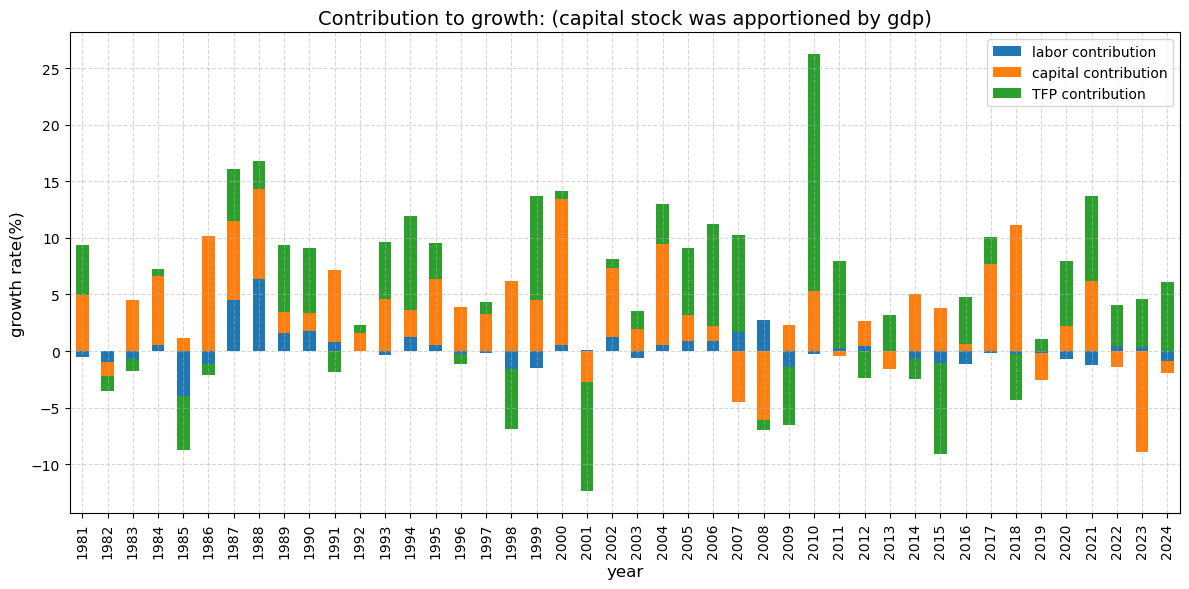

In [124]:
real_gdp = gdp_manufacturing.loc["1980": ]
employment = employment_total_manufacturing.loc["1980": ] 
capital = capital_stock_by_gdp.loc["1980": ]
labor_share = labor_distribution.loc["1980": ]

df = GrowthAccounter(real_gdp, capital, employment,  labor_share).normal_growth_accounting_calculator()
growth_accounting_visualizer(df, title_appendix="(capital stock was apportioned by gdp)")


### Share by Real GOS

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


<Figure size 1000x600 with 0 Axes>

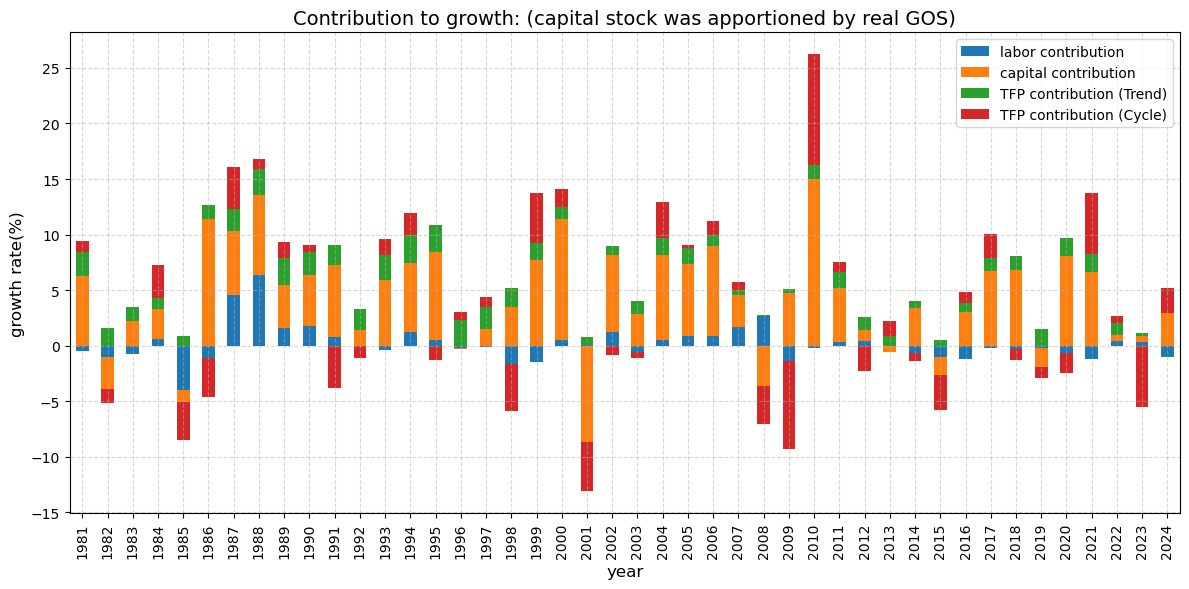

<Axes: title={'center': 'TFP trend based on real GOS share'}>

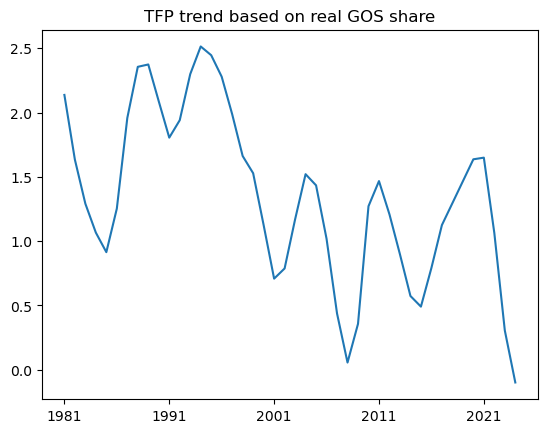

In [125]:
# Based on Real Surplus share

real_gdp = gdp_manufacturing.loc["1980": ]

employment = employment_total_manufacturing.loc["1980": ] 

capital = capital_stock_by_real_surplus.loc["1980":]
smoothed_capacity_utilization = capital_utilization_ratio_by_real_surplus["1980": ]
capital_input = capital*smoothed_capacity_utilization


labor_share = labor_distribution.loc["1980": ]

growth_accounting_by_real_gos = GrowthAccounter(real_gdp, capital_input, employment,  labor_share).decomposing_growth_accounting_calculator()
growth_accounting_visualizer(growth_accounting_by_real_gos, title_appendix="(capital stock was apportioned by real GOS)")
growth_accounting_by_real_gos["TFP contribution (Trend)"].plot(title="TFP trend based on real GOS share")


### Real Operating Surplus and Capital utilization and working hours

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


<Figure size 1000x600 with 0 Axes>

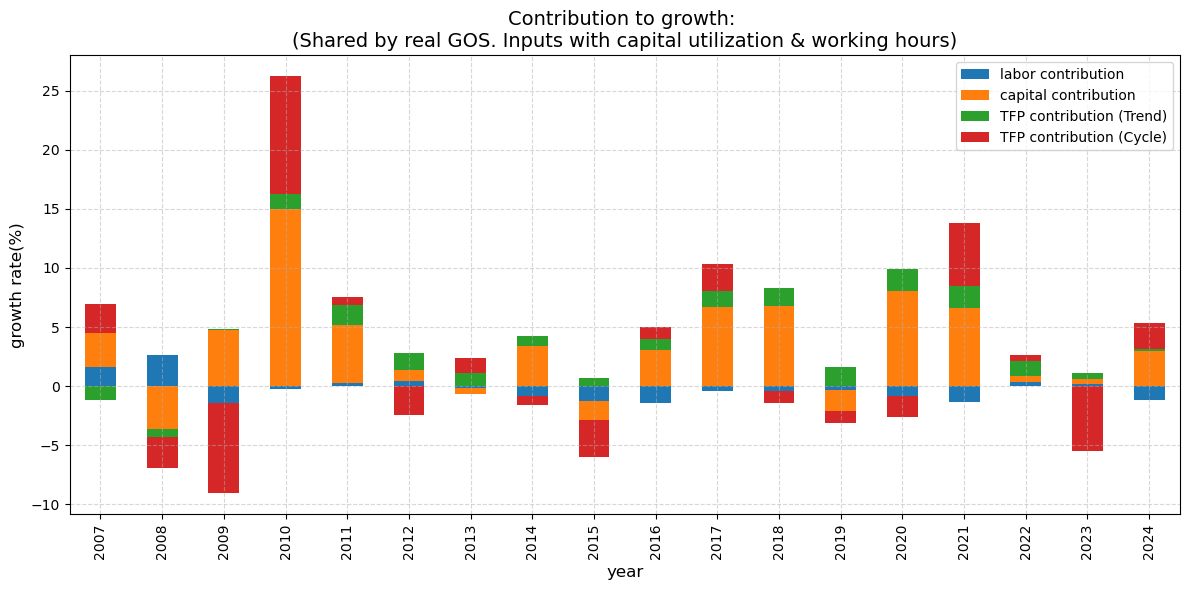

<Axes: title={'center': 'TFP trend based on real GOS share'}>

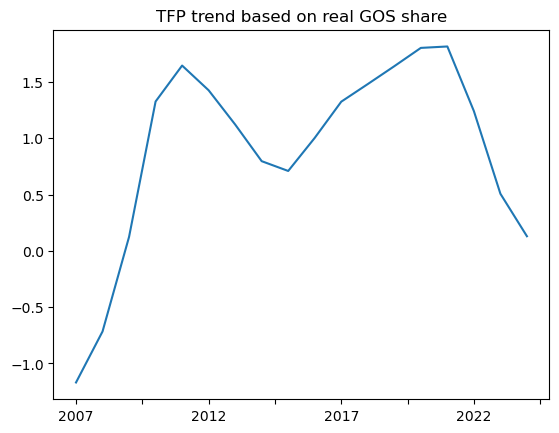

In [126]:
# Include hours

real_gdp = gdp_manufacturing.loc["2006": ]

employment = employment_total_manufacturing.loc["2006": ] 
smoothed_working_hours = working_hours["Smoothed Manufacturing"].loc["2006": ]
labor_input = employment*smoothed_working_hours

capital = capital_stock_by_real_surplus.loc["2006": ]
smoothed_capacity_utilization = capital_utilization_ratio_by_real_surplus["2006": ]
capital_input = capital*smoothed_capacity_utilization

labor_share = labor_distribution.loc["2006": ]

df = GrowthAccounter(real_gdp, capital_input, labor_input,  labor_share).decomposing_growth_accounting_calculator()
growth_accounting_visualizer(df, title_appendix="\n(Shared by real GOS. Inputs with capital utilization & working hours)")
df["TFP contribution (Trend)"].plot(title="TFP trend based on real GOS share")

### Share by fixed assets

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


<Figure size 1000x600 with 0 Axes>

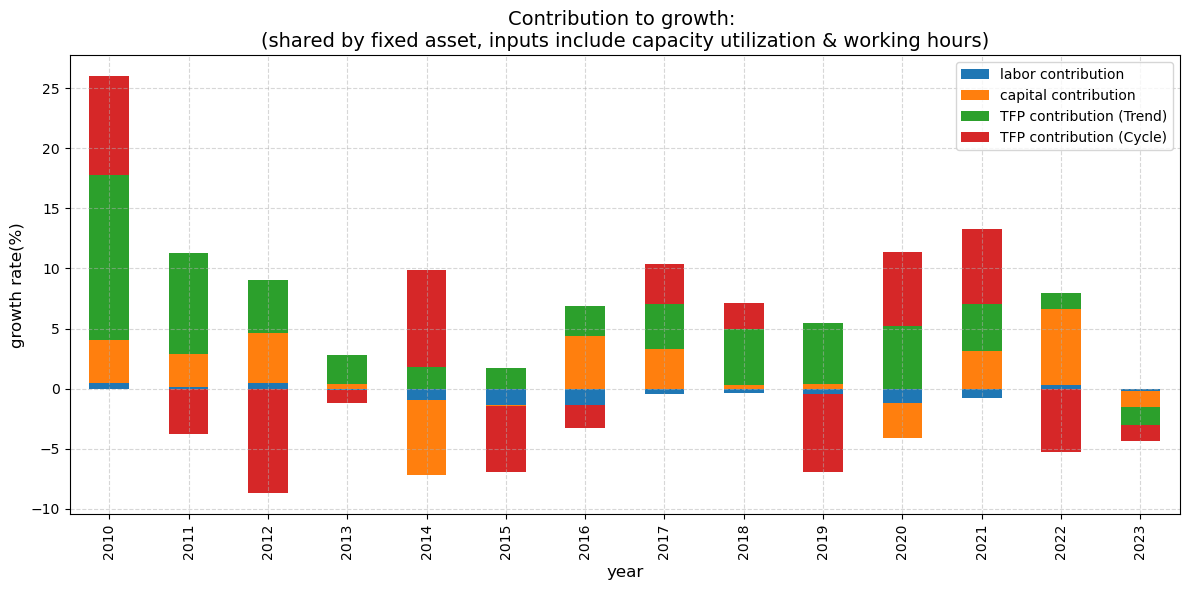

<Axes: title={'center': 'TFP trend based on fixed assets'}>

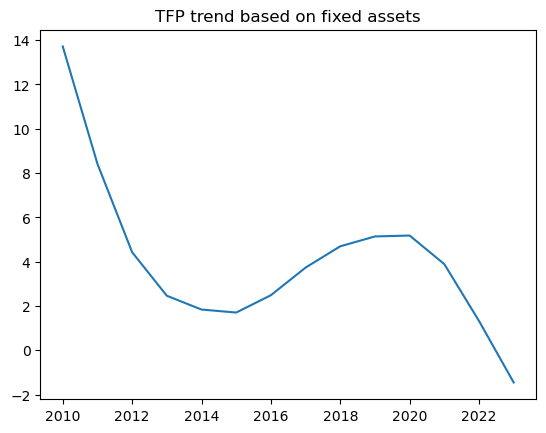

In [127]:
# Include hours & Based on fixed assets

real_gdp = gdp_manufacturing.loc["2009": "2023"]

employment = employment_total_manufacturing.loc["2009": "2023"] 
hours = working_hours["Manufacturing"].loc["2009": "2023"]
labor_input = employment * hours

capital = capital_stock_by_fixed_assets
capacity_utilization = capital_utilization_ratio_by_fixed_asset
capital_input = capital * capacity_utilization

labor_share = labor_distribution.loc["2009": "2023"]


df = GrowthAccounter(real_gdp, capital_input, labor_input,  labor_share).decomposing_growth_accounting_calculator()
growth_accounting_visualizer(df, title_appendix="\n(shared by fixed asset, inputs include capacity utilization & working hours)")
df["TFP contribution (Trend)"].plot(title="TFP trend based on fixed assets")


### Comparison Growth accounting with others


In [128]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

dataset_id = "d_2ad3e9036c289bcc2a74dfec6b2512db"
url = "https://data.gov.sg/api/action/datastore_search?resource_id="  + dataset_id 
res = requests.get(url).json()["result"]["records"]
investment_origin = {}
for col in res:
  column = col.copy()
  index = column["DataSeries"].strip()
  del column["DataSeries"]
  del column["_id"]
  investment_origin[index] = pd.Series(column).apply(pd.to_numeric, errors="coerce")
  
investment_origin_category = pd.DataFrame(investment_origin)[["Total", "Local", "Foreign"]]
investment_origin_category_share = pd.DataFrame({
  "Local share":investment_origin_category["Local"] / investment_origin_category["Total"],
  "foreign share":investment_origin_category["Foreign"] / investment_origin_category["Total"],
})

change_rate = investment_origin_category["Foreign"].shift(-1)[:-1].pct_change().dropna()
capital_contribution = growth_accounting_by_real_gos["capital contribution"]["1998": "2023"]
tfp_trend_contribution = growth_accounting_by_real_gos["TFP contribution (Trend)"]["1998": "2023"]

correlation_matrix = pd.DataFrame({"change_rate": change_rate, "capital_contribution": capital_contribution, "tfp_trend_contribution": tfp_trend_contribution}).corr()
correlation_matrix


,change_rate,capital_contribution,tfp_trend_contribution
change_rate,1.000000,0.399668,0.289624
capital_contribution,0.399668,1.000000,0.476781
tfp_trend_contribution,0.289624,0.476781,1.000000


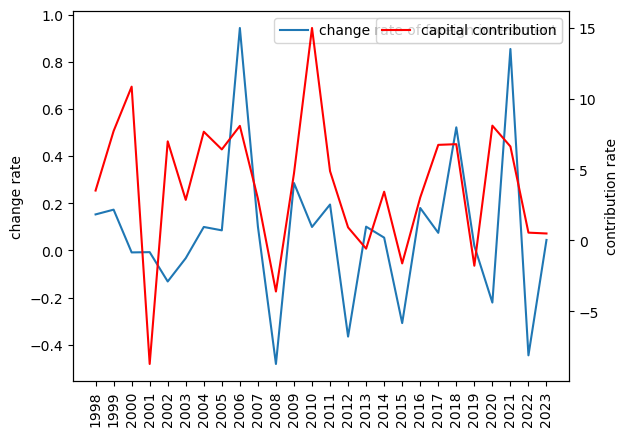

In [129]:

fig, ax1 = plt.subplots()
ax1.plot(change_rate, label="change rate of foreign investment")
ax1.set_ylabel("change rate")
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(capital_contribution, color="red", label="capital contribution")
ax2.set_ylabel("contribution rate")
ax2.legend()
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(),  rotation=90)
plt.show()

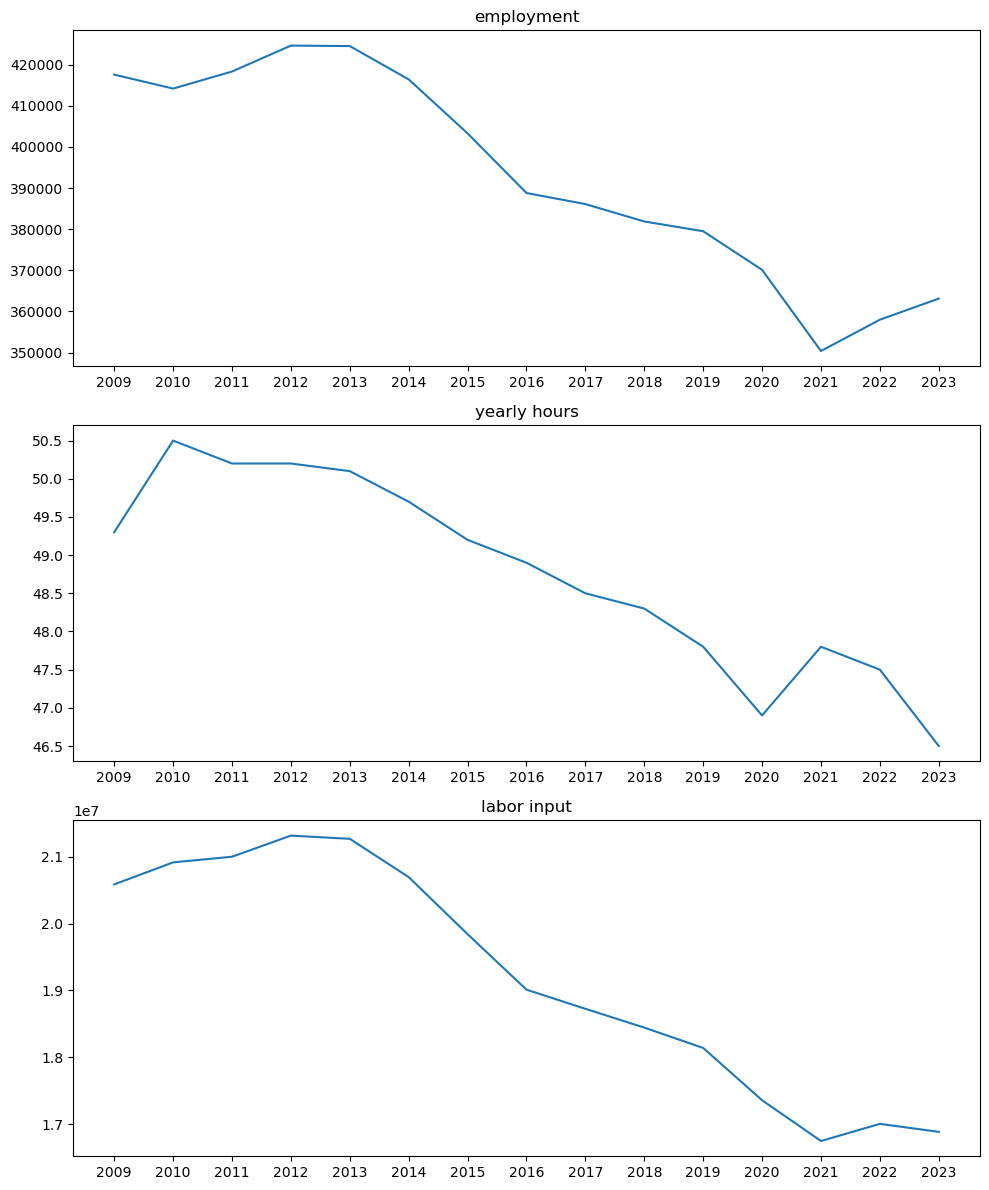

In [130]:
from matplotlib import pyplot as plt

labor_input = employment * hours
fig, ax  = plt.subplots(3, 1, figsize=(10, 12))
ax[0].plot(employment)
ax[0].set_title("employment")
ax[1].plot(hours)
ax[1].set_title("yearly hours")
ax[2].plot(labor_input)
ax[2].set_title("labor input")
fig.tight_layout()
plt.show()



### Save analysis result

In [137]:
import pandas as pd
from pathlib import Path

# 保存先のパスをPathオブジェクトとして定義
# 現在のディレクトリからの相対パス
output_dir = Path('./analysis/result/sg_manufac') 
output_file = output_dir / 'growth_accounting_by_real_gos.csv' # スラッシュでパスを結合できる
output_df = growth_accounting_by_real_gos.copy()
output_df.insert(0, "year", output_df.index)

# 親フォルダーが存在しない場合は作成する (parents=Trueで階層があってもOK)
output_dir.mkdir(parents=True, exist_ok=True)

# CSVとして保存
output_df.to_csv(output_file, index=False, encoding='utf-8')
